In [199]:
import pandas as pd
import math
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cross_validation import train_test_split
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.options.display.max_rows = 10

In [200]:
def Translate(string):
    #print string
    if len(string) >= 1:
        if string == 'One':
            return 1
        elif string[-1] == 'K':
            return float(string[0:-1])*1000
        else:
            return float(string)
    else:
        return 0
def transform(x, logswitch, stdswitch):
    if logswitch:
        x = np.log(x)
    if stdswitch:
        return x/np.std(x)
    else:
        return x

# Facebook-only Model (naive)

In [201]:
#Load dataset as df0
df0 = pd.DataFrame.from_csv('dataset.csv',header=0,index_col=None)
#create 3 actors columns, sorted by Facebook Likes
df_actors = df0['actor'].str.split(',',expand=True)
df_actors.columns = ['actor1', 'actor2', 'actor3','a']
df_actors = pd.concat([df_actors['actor3'], df_actors['actor2'], df_actors['actor1']],axis=1)
df_actors['actor1'] = df_actors['actor1'].apply(Translate)
df_actors['actor2'] = df_actors['actor2'].apply(Translate)
df_actors['actor3'] = df_actors['actor3'].apply(Translate)
#concatenate it to the rest of the dataframe
df = pd.concat([df0, df_actors],axis=1)
df = df.drop_duplicates('url').reset_index()
df['likes'] = df['likes'].apply(Translate)
df['writer'] = df['writer'].apply(Translate)
df['director'] = df['director'].apply(Translate)
df['year'] = df['year'].apply(int)
df = pd.concat([df.iloc[:,2:6], df.iloc[:,8:]],axis=1);
years = pd.unique(df.year)
dfnew = df
stdswitch = 1 #1 ~ standardize the data
logswitch = 1 #1 ~ take the log of the data first

In [202]:
criteria = (df.year <= 2020)
dfnew.actor1[criteria] = transform(df.actor1[criteria],logswitch,stdswitch)
dfnew.actor2[criteria] = transform(df.actor2[criteria],logswitch,stdswitch)
dfnew.actor3[criteria] = transform(df.actor3[criteria],logswitch,stdswitch)
dfnew.director[criteria] = transform(df.director[criteria],logswitch,stdswitch)
dfnew.writer[criteria] = transform(df.writer[criteria],logswitch,stdswitch)
dfnew.metacritic[criteria] = transform(df.metacritic[criteria],logswitch,stdswitch)
dfnew.imdb[criteria] = transform(df.imdb[criteria],logswitch,stdswitch)
dfnew.likes[criteria] = transform(df.likes[criteria],logswitch,stdswitch)

In [203]:
df = dfnew
ones = (df.director*0+1)
ones = ones.rename('bias')
actors = (df.actor1+df.actor2+df.actor3)/3.0
aL = actors.rename('actors_likes')
dL = df.director.rename('director_likes');
wL = df.writer.rename('writer_likes');
mL = df.likes.rename('movie_likes');
critic = df.metacritic
df = pd.concat([critic, ones, aL, dL, wL, mL], axis=1);
df = df.dropna()
y = df.iloc[:,0]
X = df.iloc[:,1:];

In [204]:
df.to_csv('facebooknaive.csv',index=False)

# Facebook-only Model (Grouped)

In [184]:
#Load dataset as df0
df0 = pd.DataFrame.from_csv('dataset.csv',header=0,index_col=None)
#create 3 actors columns, sorted by Facebook Likes
df_actors = df0['actor'].str.split(',',expand=True)
df_actors.columns = ['actor1', 'actor2', 'actor3','a']
df_actors = pd.concat([df_actors['actor3'], df_actors['actor2'], df_actors['actor1']],axis=1)
df_actors['actor1'] = df_actors['actor1'].apply(Translate)
df_actors['actor2'] = df_actors['actor2'].apply(Translate)
df_actors['actor3'] = df_actors['actor3'].apply(Translate)
#concatenate it to the rest of the dataframe
df = pd.concat([df0, df_actors],axis=1)
df = df.drop_duplicates('url').reset_index()
df['likes'] = df['likes'].apply(Translate)
df['writer'] = df['writer'].apply(Translate)
df['director'] = df['director'].apply(Translate)
df['year'] = df['year'].apply(int)
df = pd.concat([df.iloc[:,2:6], df.iloc[:,8:]],axis=1);
years = pd.unique(df.year)
dfnew = df
stdswitch = 1 #1 ~ standardize the data
logswitch = 1 #1 ~ take the log of the data first

In [185]:
#scale films 1993 and before as one group
criteria = (df.year <= 1993)
dfnew.actor1[criteria] = transform(df.actor1[criteria],logswitch,stdswitch)
dfnew.actor2[criteria] = transform(df.actor2[criteria],logswitch,stdswitch)
dfnew.actor3[criteria] = transform(df.actor3[criteria],logswitch,stdswitch)
dfnew.director[criteria] = transform(df.director[criteria],logswitch,stdswitch)
dfnew.writer[criteria] = transform(df.writer[criteria],logswitch,stdswitch)
dfnew.metacritic[criteria] = transform(df.metacritic[criteria],logswitch,stdswitch)
dfnew.imdb[criteria] = transform(df.imdb[criteria],logswitch,stdswitch)
dfnew.likes[criteria] = transform(df.likes[criteria],logswitch,stdswitch)

In [186]:
#1997 - 2017, we scale with films of the same year (because there are enough data)
for yr in range(1994,2017):
    criteria = df.year == yr
    dfnew.actor1[criteria] = transform(df.actor1[criteria],logswitch,stdswitch)
    dfnew.actor2[criteria] = transform(df.actor2[criteria],logswitch,stdswitch)
    dfnew.actor3[criteria] = transform(df.actor3[criteria],logswitch,stdswitch)
    dfnew.director[criteria] = transform(df.director[criteria],logswitch,stdswitch)
    dfnew.writer[criteria] = transform(df.writer[criteria],logswitch,stdswitch)
    dfnew.metacritic[criteria] = transform(df.metacritic[criteria],logswitch,stdswitch)
    dfnew.imdb[criteria] = transform(df.imdb[criteria],logswitch,stdswitch)
    dfnew.likes[criteria] = transform(df.likes[criteria],logswitch,stdswitch)
dfnew.year = transform(df.year,0,0)

In [187]:
df = dfnew
ones = (df.director*0+1)
ones = ones.rename('bias')
actors = (df.actor1+df.actor2+df.actor3)/3.0
aL = actors.rename('actors_likes')
dL = df.director.rename('director_likes');
wL = df.writer.rename('writer_likes');
mL = df.likes.rename('movie_likes');
critic = df.metacritic
df = pd.concat([critic, ones, aL, dL, wL, mL], axis=1);
df = df.dropna()
y = df.iloc[:,0]
X = df.iloc[:,1:];

,bias,actors_likes,director_likes,writer_likes,movie_likes
0,1.0,0.534921,2.542807,2.068782,7.275998
1,1.0,2.104764,2.465665,2.296811,3.751087
2,1.0,0.462073,2.539735,0.000000,7.264716
3,1.0,0.354804,0.000000,0.000000,4.924773
4,1.0,2.375781,0.500139,0.484480,5.440450
...,...,...,...,...,...
3316,1.0,5.511515,3.313074,1.554985,6.266812
3317,1.0,4.232139,2.432356,0.782276,7.562739
3318,1.0,3.710508,2.298842,1.743889,4.740663
3319,1.0,3.509468,0.000000,0.000000,4.612392


In [189]:
df.to_csv('facebook.csv',index=False)

In [190]:
totalscore = 0
for i in range(0,10):  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
    model = sm.OLS(y_train, X_train) 
    fit = model.fit()
    y_pred = fit.predict(X_test)
    score = metrics.r2_score(y_test, y_pred)
    print('Adj. r^2 score on iteration ' + str(i+1) + ': ' + str(score))
    totalscore += score
print('mean adj. r^2 score: '+ str(totalscore/10))

Adj. r^2 score on iteration 1: 0.214977570234
Adj. r^2 score on iteration 2: 0.216601165819
Adj. r^2 score on iteration 3: 0.224826979031
Adj. r^2 score on iteration 4: 0.203634966584
Adj. r^2 score on iteration 5: 0.226439891972
Adj. r^2 score on iteration 6: 0.221054044545
Adj. r^2 score on iteration 7: 0.193189601697
Adj. r^2 score on iteration 8: 0.210439733724
Adj. r^2 score on iteration 9: 0.19065391351
Adj. r^2 score on iteration 10: 0.216901083503
mean adj. r^2 score: 0.211871895062


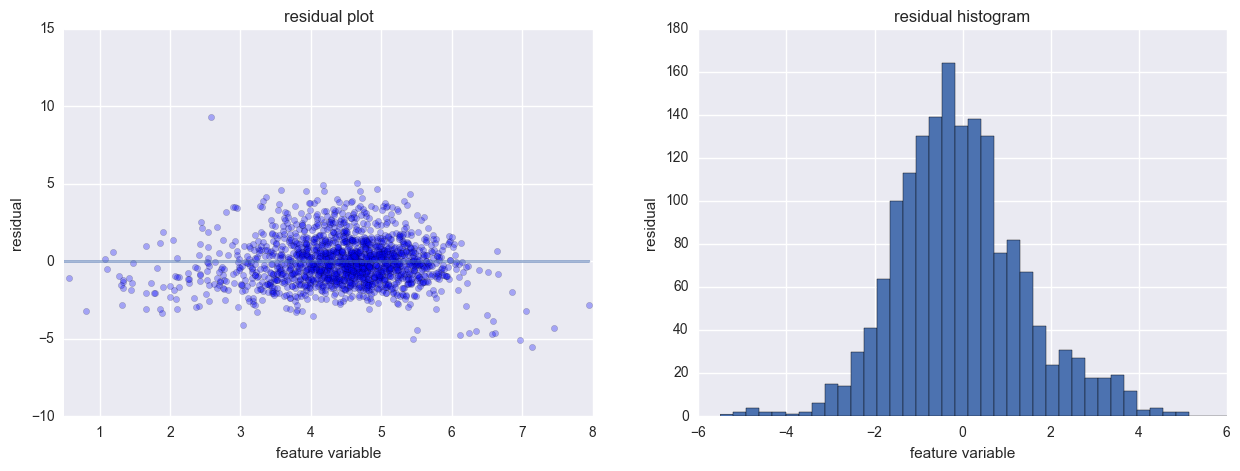

In [191]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.scatter(X_test.iloc[:,1], y_pred-y_test,alpha = .3)
plt.plot(X_test.iloc[:,1],X_test.iloc[:,1]*0,alpha = .5)
plt.xlabel('feature variable')
plt.ylabel('residual')
plt.xlim([0.5,8])
plt.title('residual plot');

plt.subplot(1,2,2)
plt.hist(y_pred-y_test,bins = 50)
plt.xlabel('feature variable')
plt.ylabel('residual')
plt.xlim([-6,6])
plt.title('residual histogram');

In [192]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             metacritic   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     111.1
Date:                Wed, 05 Oct 2016   Prob (F-statistic):           5.76e-84
Time:                        13:03:15   Log-Likelihood:                -3076.2
No. Observations:                1660   AIC:                             6162.
Df Residuals:                    1655   BIC:                             6190.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
bias               6.3368      0.229     27.633      0.000         5.887     6.787
actors_likes       0.0362      0.042      0.871      0.384        -0.045     0.118
director_likes     0.1207      0.045      2.703      0.007         0.033     0.208
writer_likes       0.0181      0.043      0.421      0.674        -0.066     0.103
movie_likes        0.5206      0.031     16.679      0.000         0.459     0.582
==============================================================================
Omnibus:                       90.661   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              159.752
Skew:                          -0.412   Prob(JB):                     2.04e-35
Kurtosis:                       4.277   Cond. No.                         53.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Facebook + Awards Model
Let's do this with awards information attached...

In [193]:
#Load Facebook dataset as df0
df0 = pd.DataFrame.from_csv('dataset.csv',header=0,index_col=None)
#load awards data set as df1
df1 = pd.DataFrame.from_csv('datasetawards.csv',header=0,index_col=None)
#join the two sets
df0 = df0.merge(df1, left_on='url', right_on='url', how='inner')

In [194]:
#create 3 actors columns, sorted by Facebook Likes
df_actors = df0['actor'].str.split(',',expand=True)
df_actors.columns = ['actor1', 'actor2', 'actor3','a']
df_actors = pd.concat([df_actors['actor3'], df_actors['actor2'], df_actors['actor1']],axis=1)
df_actors['actor1'] = df_actors['actor1'].apply(Translate)
df_actors['actor2'] = df_actors['actor2'].apply(Translate)
df_actors['actor3'] = df_actors['actor3'].apply(Translate)
#concatenate it to the rest of the dataframe
df = pd.concat([df0, df_actors],axis=1)
df = df.drop_duplicates('url').reset_index()
df['likes'] = df['likes'].apply(Translate)
df['writer'] = df['writer'].apply(Translate)
df['director'] = df['director'].apply(Translate)
df['year'] = df['year'].apply(int)
df = pd.concat([df.iloc[:,2:6], df.iloc[:,8:]],axis=1);
years = pd.unique(df.year)
dfnew = df
stdswitch = 1 #1 ~ standardize the data
logswitch = 1 #1 ~ take the log of the data first

#scale films 1993 and before as one group
criteria = (df.year <= 1993)
dfnew.actor1[criteria] = transform(df.actor1[criteria],logswitch,stdswitch)
dfnew.actor2[criteria] = transform(df.actor2[criteria],logswitch,stdswitch)
dfnew.actor3[criteria] = transform(df.actor3[criteria],logswitch,stdswitch)
dfnew.director[criteria] = transform(df.director[criteria],logswitch,stdswitch)
dfnew.writer[criteria] = transform(df.writer[criteria],logswitch,stdswitch)
dfnew.metacritic[criteria] = transform(df.metacritic[criteria],logswitch,stdswitch)
dfnew.imdb[criteria] = transform(df.imdb[criteria],logswitch,stdswitch)
dfnew.likes[criteria] = transform(df.likes[criteria],logswitch,stdswitch)
dfnew.actor_awd[criteria] = transform(df.actor_awd[criteria]+1,logswitch,stdswitch)
dfnew.dir_awd[criteria] = transform(df.dir_awd[criteria]+1,logswitch,stdswitch)
dfnew.writer_awd[criteria] = transform(df.writer_awd[criteria]+1,logswitch,stdswitch)

#1997 - 2017, we scale with films of the same year (because there are enough data)
for yr in range(1994,2017):
    criteria = df.year == yr
    dfnew.actor1[criteria] = transform(df.actor1[criteria],logswitch,stdswitch)
    dfnew.actor2[criteria] = transform(df.actor2[criteria],logswitch,stdswitch)
    dfnew.actor3[criteria] = transform(df.actor3[criteria],logswitch,stdswitch)
    dfnew.director[criteria] = transform(df.director[criteria],logswitch,stdswitch)
    dfnew.writer[criteria] = transform(df.writer[criteria],logswitch,stdswitch)
    dfnew.metacritic[criteria] = transform(df.metacritic[criteria],logswitch,stdswitch)
    dfnew.imdb[criteria] = transform(df.imdb[criteria],logswitch,stdswitch)
    dfnew.likes[criteria] = transform(df.likes[criteria],logswitch,stdswitch)
    dfnew.actor_awd[criteria] = transform(df.actor_awd[criteria]+1,logswitch,stdswitch)
    dfnew.dir_awd[criteria] = transform(df.dir_awd[criteria]+1,logswitch,stdswitch)
    dfnew.writer_awd[criteria] = transform(df.writer_awd[criteria]+1,logswitch,stdswitch)

dfnew.year = transform(df.year,0,0)

In [195]:
df = dfnew
actors = (df.actor1+df.actor2+df.actor3)/3
aL = actors.rename('actors_likes')
dL = df.director.rename('director_likes');
wL = df.writer.rename('writer_likes');
mL = df.likes.rename('movie_likes');
aW = df.actor_awd.rename('actors_awards')
dW = df.dir_awd.rename('director_awards')
wW = df.writer_awd.rename('writer_awards')
ones = (df.director*0+1)
ones = ones.rename('bias')
critic = df.metacritic
df = pd.concat([critic, ones, aL, dL, wL, mL, aW, dW, wW], axis=1);
df = df.dropna()
y = df.iloc[:,0]
X = df.iloc[:,1:];X

,bias,actors_likes,director_likes,writer_likes,movie_likes,actors_awards,director_awards,writer_awards
0,1.0,0.534921,2.542807,2.068782,7.275998,0.581400,2.741758,2.505667
1,1.0,2.104764,2.465665,2.296811,3.751087,1.399190,1.612615,1.457766
2,1.0,0.462073,2.539735,0.000000,7.264716,0.000000,2.189215,0.000000
3,1.0,0.354804,0.000000,0.000000,4.924773,0.000000,0.000000,0.000000
4,1.0,2.375781,0.500139,0.484480,5.440450,4.392840,0.936926,0.940264
...,...,...,...,...,...,...,...,...
3314,1.0,5.511515,3.313074,1.554985,6.266812,5.837487,2.386057,0.420352
3315,1.0,4.232139,2.432356,0.782276,7.562739,1.721537,0.466321,0.922450
3316,1.0,3.710508,2.298842,1.743889,4.740663,5.606205,2.489426,2.028749
3317,1.0,3.509468,0.000000,0.000000,4.612392,3.244166,0.000000,0.000000


In [196]:
df.to_csv('facebook_awd.csv',index=False)

In [179]:
totalscore = 0
for i in range(0,10):  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
    model = sm.OLS(y_train, X_train) 
    fit = model.fit()
    y_pred = fit.predict(X_test)
    score = metrics.r2_score(y_test, y_pred)
    print('Adj. r^2 score on iteration ' + str(i+1) + ': ' + str(score))
    totalscore += score
print('mean adj. r^2 score: '+ str(totalscore/10))

Adj. r^2 score on iteration 1: 0.288115650474
Adj. r^2 score on iteration 2: 0.298021311851
Adj. r^2 score on iteration 3: 0.308292778178
Adj. r^2 score on iteration 4: 0.294116495066
Adj. r^2 score on iteration 5: 0.300452039131
Adj. r^2 score on iteration 6: 0.295504696239
Adj. r^2 score on iteration 7: 0.307410961823
Adj. r^2 score on iteration 8: 0.315964358908
Adj. r^2 score on iteration 9: 0.288063153234
Adj. r^2 score on iteration 10: 0.306433043222
mean adj. r^2 score: 0.300237448813


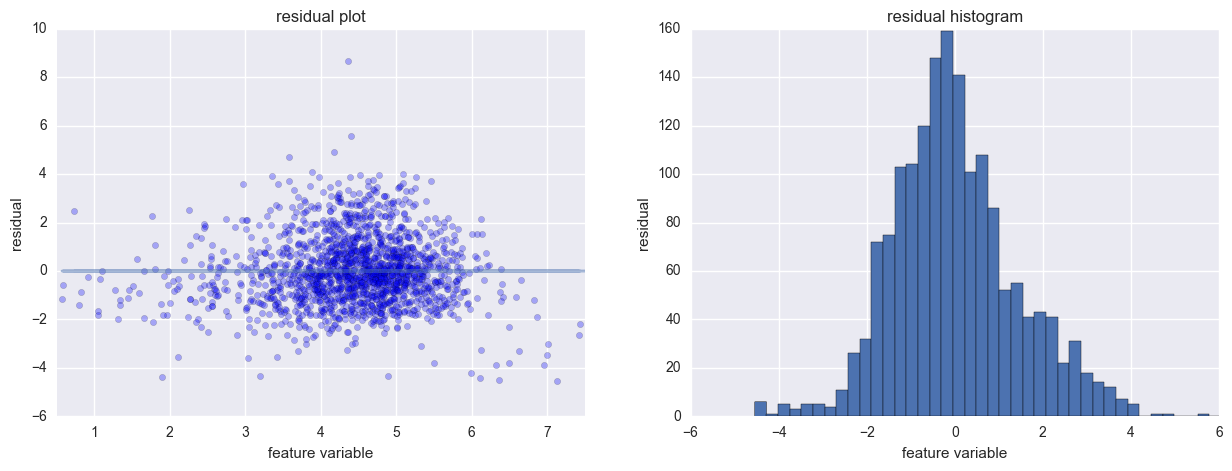

In [180]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.scatter(X_test.iloc[:,1], y_pred-y_test,alpha = .3)
plt.plot(X_test.iloc[:,1],X_test.iloc[:,1]*0,alpha = .5)
plt.xlabel('feature variable')
plt.ylabel('residual')
plt.xlim([0.5,7.5])
plt.title('residual plot');

plt.subplot(1,2,2)
plt.hist(y_pred-y_test,bins = 50)
plt.xlabel('feature variable')
plt.ylabel('residual')
plt.xlim([-6,6])
plt.title('residual histogram');

In [181]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             metacritic   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     97.82
Date:                Wed, 05 Oct 2016   Prob (F-statistic):          1.14e-119
Time:                        12:59:25   Log-Likelihood:                -2959.6
No. Observations:                1659   AIC:                             5935.
Df Residuals:                    1651   BIC:                             5979.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
bias                6.0174      0.213     28.295      0.000         5.600     6.435
actors_likes       -0.2730      0.057     -4.800      0.000        -0.385    -0.161
director_likes     -0.0840      0.055     -1.539      0.124        -0.191     0.023
writer_likes       -0.0993      0.056     -1.775      0.076        -0.209     0.010
movie_likes         0.5485      0.029     18.800      0.000         0.491     0.606
actors_awards       0.3790      0.043      8.751      0.000         0.294     0.464
director_awards     0.2187      0.056      3.893      0.000         0.108     0.329
writer_awards       0.1753      0.058      3.019      0.003         0.061     0.289
==============================================================================
Omnibus:                       91.060   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.659
Skew:                          -0.472   Prob(JB):                     9.47e-30
Kurtosis:                       4.021   Cond. No.                         60.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""